In [94]:
# relevant imports
from torch import nn
from datasets import load_dataset
from torchvision.transforms import transforms
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from torchvision.datasets import Cityscapes
import torch
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import OxfordIIITPet
from typing import List


In [2]:
class UNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(UNet, self).__init__()

        # Encoder Blocks
        self.encoder_block_1 = UNet._conv_block(input_size, 32)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_block_2 = UNet._conv_block(32, 64)
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_block_3 = UNet._conv_block(64, 128)
        self.max_pool_3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_block_4 = UNet._conv_block(128, 256)
        self.max_pool_4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottle_neck_block = UNet._conv_block(256, 512)

        # Decoder Blocks
        self.upconv_block_4 = UNet._upconv_block(512, 256)
        self.decoder_block_4 = UNet._conv_block(512, 256)

        self.upconv_block_3 = UNet._upconv_block(256, 128)
        self.decoder_block_3 = UNet._conv_block(256, 128)

        self.upconv_block_2 = UNet._upconv_block(128, 64)
        self.decoder_block_2 = UNet._conv_block(128, 64)

        self.upconv_block_1 = UNet._upconv_block(64, 32)
        self.decoder_block_1 = UNet._conv_block(64, 32)

        # Output convolution
        self.fc = nn.Conv2d(32, output_size, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder_block_1(x)
        e2 = self.encoder_block_2(self.max_pool_1(e1))
        e3 = self.encoder_block_3(self.max_pool_2(e2))
        e4 = self.encoder_block_4(self.max_pool_3(e3))

        b = self.bottle_neck_block(self.max_pool_4(e4))

        d4 = self.upconv_block_4(b)
        d4 = self.decoder_block_4(torch.cat((d4, e4), dim=1))
        d3 = self.upconv_block_3(d4)
        d3 = self.decoder_block_3(torch.cat((d3, e3), dim=1))
        d2 = self.upconv_block_2(d3)
        d2 = self.decoder_block_2(torch.cat((d2, e2), dim=1))
        d1 = self.upconv_block_1(d2)
        d1 = self.decoder_block_1(torch.cat((d1, e1), dim=1))

        return self.fc(d1)

    @staticmethod
    def _conv_block(input_size, output_size):
        return nn.Sequential(
            nn.Conv2d(input_size, output_size, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(output_size),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_size, output_size, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(output_size),
            nn.ReLU(inplace=True))

    @staticmethod
    def _upconv_block(input_size, output_size):
        return nn.ConvTranspose2d(input_size, output_size, kernel_size=2, stride=2)

In [3]:
class SegNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(SegNet, self).__init__()

        # Encoder Blocks
        self.encoder_block_1 = SegNet._conv_block(input_size, 32)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.encoder_block_2 = SegNet._conv_block(32, 64)
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.encoder_block_3 = SegNet._conv_block(64, 128)
        self.max_pool_3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.encoder_block_4 = SegNet._conv_block(128, 256)
        self.max_pool_4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # Bottleneck
        self.bottle_neck_block_1 = SegNet._conv_block(256, 512)
        self.max_pool_5 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.max_unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        # Decoder Blocks
        self.decoder_block_5 = SegNet._conv_block(512, 256)

        self.unpool_block_4 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder_block_4 = SegNet._conv_block(256, 128)

        self.unpool_block_3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder_block_3 = SegNet._conv_block(128, 64)

        self.unpool_block_2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder_block_2 = SegNet._conv_block(64, 32)

        self.unpool_block_1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder_block_1 = SegNet._conv_block(32, 32)

        self.fc = nn.Conv2d(32, output_size, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder_block_1(x)
        e1_1, i1 = self.max_pool_1(e1)

        e2 = self.encoder_block_2(e1_1)
        e2_1, i2 = self.max_pool_2(e2)

        e3 = self.encoder_block_3(e2_1)
        e3_1, i3 = self.max_pool_3(e3)

        e4 = self.encoder_block_4(e3_1)
        e4_1, i4 = self.max_pool_4(e4)

        b = self.bottle_neck_block_1(e4_1)
        b, i5 = self.max_pool_5(b)
        b_unpool = self.max_unpool(b, i5)
        b = self.decoder_block_5(b_unpool)

        d4 = self.unpool_block_4(b, i4)
        d4 = self.decoder_block_4(d4)

        d3 = self.unpool_block_3(d4, i3)
        d3 = self.decoder_block_3(d3)

        d2 = self.unpool_block_2(d3, i2)
        d2 = self.decoder_block_2(d2)

        d1 = self.unpool_block_1(d2, i1)
        d1 = self.decoder_block_1(d1)

        return self.fc(d1)


    @staticmethod
    def _conv_block(input_size, output_size):
        return nn.Sequential(
            nn.Conv2d(input_size, output_size, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(output_size),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_size, output_size, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(output_size),
            nn.ReLU(inplace=True))

In [4]:
isic18_dataset = load_dataset("surajbijjahalli/ISIC2018")
isic18_dataset

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2594
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

In [5]:
class ISICDataset(Dataset):
    def __init__(self, dataset, transform_image=None, transform_mask=None):
        self.dataset = dataset
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]

        image = example['image']
        mask = example['label']
        mask = mask.convert('L')
        mask = np.array(mask)
        mask[mask > 0] = 255
        mask[mask == 0] = 0
        mask = Image.fromarray(mask)

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

In [38]:
transform_image = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([.5, .5, .5], [.5, .5, .5])])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.ToTensor()])

isic18_test_dataset = ISICDataset(isic18_dataset['test'], transform_image, transform_mask)

In [138]:
transform_image = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([.5, .5, .5], [.5, .5, .5]),
])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda mask: mask - 1),
])

In [139]:
dataset = OxfordIIITPet(
    root="~/res",
    split="trainval",
    target_types=["segmentation"],
    download=True,
    transform=transform_image,
    target_transform=transform_mask
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

torch.manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [202]:
transform_image = transforms.Compose([
    transforms.Resize((256, 512), interpolation=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([.5, .5, .5], [.5, .5, .5])])

transform_mask = transforms.Compose([
    transforms.Resize((256, 512), interpolation=Image.NEAREST),
    transforms.PILToTensor()])

val_dataset = Cityscapes(root='~/res/datasets',
                         split='val',
                         mode='fine',
                         target_type='semantic',
                         transform=transform_image,
                         target_transform=transform_mask)


In [7]:
def load_checkpoint(path: Path, model: torch.nn.Module) -> torch.nn.Module:
    """
    Helper method to load a model from a checkpoint
    :param path: path to checkpoint
    :param model: model which should use the checkpoint
    :return: loaded model
    """
    device: torch.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    checkpoint = torch.load(path, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint)
    return model

In [46]:
def visualize_binary_sample(models: List[torch.nn.Module], dataset: Dataset, index: int, device) -> None:
    
    image, mask = dataset[index]
    image = image.unsqueeze(0).to(device)
    mask = mask.numpy().squeeze()

    predictions = []
    with torch.no_grad():
        for model in models: 
            model.eval()
            pred = model(image)
            pred = torch.sigmoid(pred)
            pred = pred.cpu().numpy().squeeze()
            pred = np.where(pred > 0.5, 1, 0)
            predictions.append(pred)
            
    denorm_image = denormalize(image.cpu(), [.5, .5, .5], [.5, .5, .5])
    denorm_image = torch.clamp(denorm_image[0], 0, 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1)
    plt.title("Image")
    plt.imshow(denorm_image.cpu().permute(1, 2, 0))

    plt.subplot(1, 4, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask, cmap='gray')

    plt.subplot(1, 4, 3)
    plt.title("Prediction Unet")
    plt.imshow(predictions[0], cmap='gray')

    plt.subplot(1, 4, 4)
    plt.title("Prediction SegNet")
    plt.imshow(predictions[1], cmap='gray')
    plt.show()

In [12]:
def denormalize(tensor: torch.Tensor, mean: List[float], std: List[float]) -> torch.Tensor:
    mean = torch.tensor(mean).view(1, 3, 1, 1)
    std = torch.tensor(std).view(1, 3, 1, 1)
    tensor = tensor * std + mean
    return tensor

In [123]:
test_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
device: torch.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
unet = UNet(3, 1).to(device)
segnet = SegNet(3, 1).to(device)

unet = load_checkpoint(Path('../../res/checkpoints/unet_isic18.pt'), unet)
segnet = load_checkpoint(Path('../../res/checkpoints/segnet_isic18.pt'), segnet)


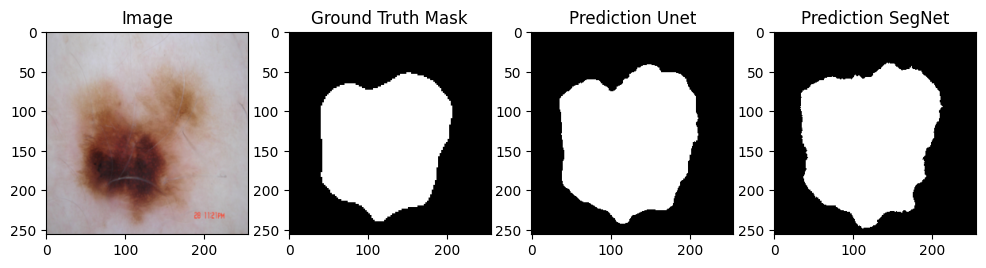

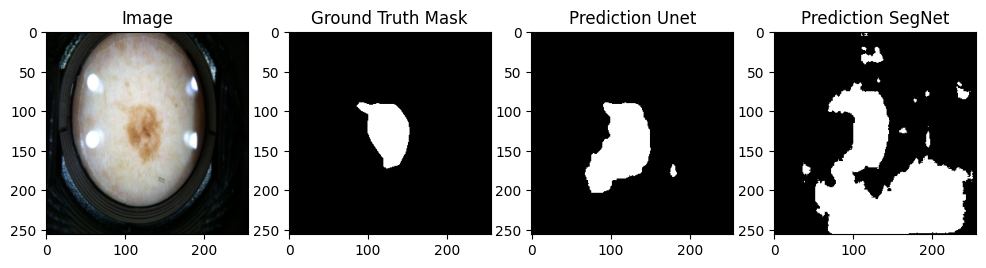

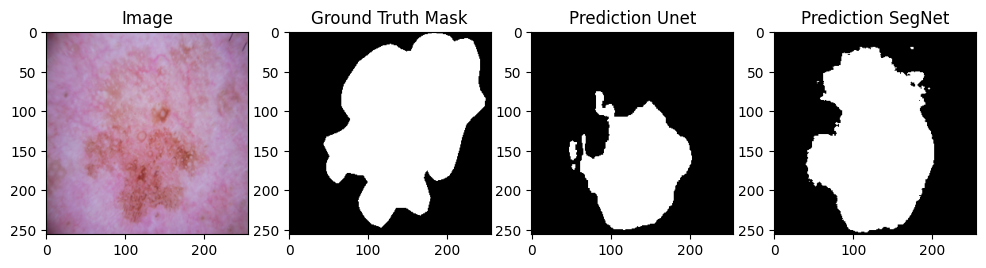

In [137]:
visualize_binary_sample((unet, segnet), isic18_test_dataset, 600, device)
visualize_binary_sample((unet, segnet), isic18_test_dataset, 601, device)
visualize_binary_sample((unet, segnet), isic18_test_dataset, 602, device)


In [140]:
def visualize_sample(models: List[torch.nn.Module], dataset: Dataset, index: int, device) -> None:
    image, mask = dataset[index]
    image = image.unsqueeze(0).to(device)
    mask = mask.numpy().squeeze()

    predictions = []
    with torch.no_grad():
        for model in models:
            model.eval()
            pred = model(image)
            pred = torch.softmax(pred, dim=1)
            pred = torch.argmax(pred, dim=1).cpu().numpy().squeeze()
            predictions.append(pred)

    denorm_image = denormalize(image.cpu(), [.5, .5, .5], [.5, .5, .5])
    denorm_image = torch.clamp(denorm_image[0], 0, 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1)
    plt.title("Image")
    plt.imshow(denorm_image.cpu().permute(1, 2, 0))

    plt.subplot(1, 4, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask, cmap='tab10')

    plt.subplot(1, 4, 3)
    plt.title("Prediction Unet")
    plt.imshow(predictions[0], cmap='tab10')

    plt.subplot(1, 4, 4)
    plt.title("Prediction SegNet")
    plt.imshow(predictions[1], cmap='tab10')
    plt.show()

In [141]:
test_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
device: torch.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
unet = UNet(3, 3).to(device)
segnet = SegNet(3, 3).to(device)

unet = load_checkpoint(Path('../../res/checkpoints/unet_pets.pt'), unet)
segnet = load_checkpoint(Path('../../res/checkpoints/segnet_pets.pt'), segnet)


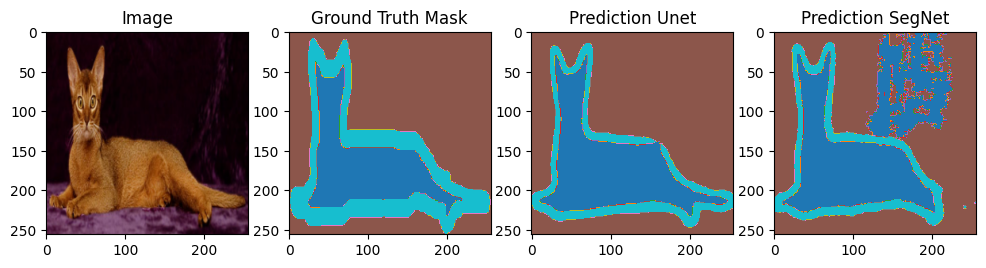

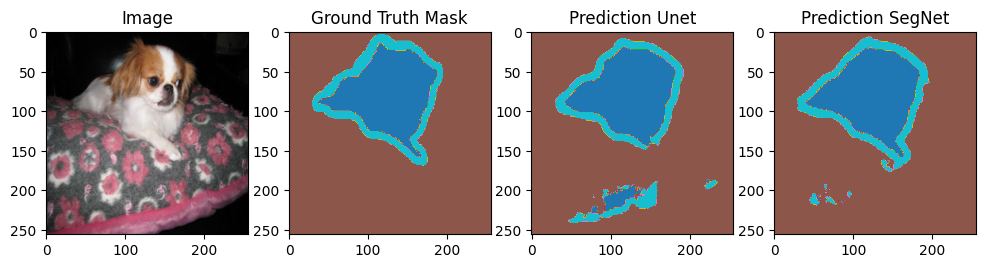

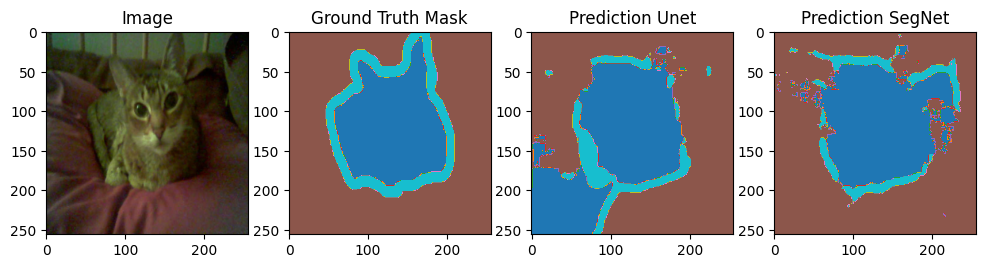

In [201]:
visualize_sample((unet, segnet), val_dataset, 312, device)
visualize_sample((unet, segnet), val_dataset, 313, device)
visualize_sample((unet, segnet), val_dataset, 314, device)



In [203]:
test_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
device: torch.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
unet = UNet(3, 35).to(device)
segnet = SegNet(3, 35).to(device)

unet = load_checkpoint(Path('../../res/checkpoints/unet_cityscapes.pt'), unet)
segnet = load_checkpoint(Path('../../res/checkpoints/segnet_cityscape.pt'), segnet)


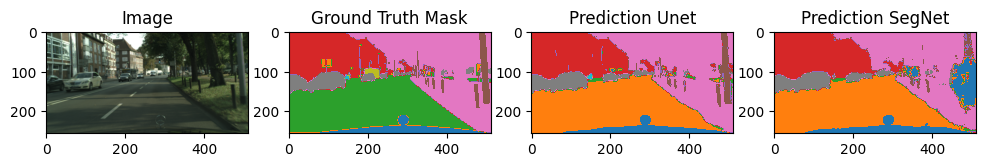

In [206]:
visualize_sample((unet, segnet), val_dataset, 6, device)